<a href="https://colab.research.google.com/github/willtscott/Kaggle/blob/master/Whales%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Humpback Whale Identification with MobileNet
* This kernel is based on 
<br>@Ankit : https://www.kaggle.com/satian/keras-mobilenet-starter, which is a combination of 
<br>@peter : https://www.kaggle.com/pestipeti/keras-cnn-starter and 
<br>@beluga: https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892 from google doodle quickdraw competition

>“There is, one knows not what sweet mystery about this sea, whose gently awful stirrings seem to speak of some hidden soul beneath...” 
<br>**― Herman Melville**, *Moby-Dick or, The Whale*

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"willtscott","key":"2d7623e0b25fb4023edcc55dce7ed240"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
import os
!mkdir whales
!mkdir whales/input
!mkdir whales/kernel
os.chdir('whales/input')

In [5]:
!kaggle competitions download -c humpback-whale-identification

  0% 0.00/498k [00:00<?, ?B/s]
100% 498k/498k [00:00<00:00, 79.0MB/s]
  0% 0.00/594k [00:00<?, ?B/s]
100% 594k/594k [00:00<00:00, 95.4MB/s]
 99% 1.34G/1.35G [00:10<00:00, 138MB/s]
100% 1.35G/1.35G [00:10<00:00, 142MB/s]
100% 4.14G/4.16G [00:30<00:00, 110MB/s]
100% 4.16G/4.16G [00:30<00:00, 147MB/s]


In [6]:
!mkdir train
!unzip train.zip -d train

Archive:  train.zip
  inflating: train/1cb7e70be.jpg     
  inflating: train/85fbaaeee.jpg     
  inflating: train/0df6c0ada.jpg     
  inflating: train/b45879784.jpg     
  inflating: train/667c90122.jpg     
  inflating: train/d78425146.jpg     
  inflating: train/52fb69ef4.jpg     
  inflating: train/e6b70421a.jpg     
  inflating: train/57c35256c.jpg     
  inflating: train/fdda50025.jpg     
  inflating: train/b642373be.jpg     
  inflating: train/38d49de1f.jpg     
  inflating: train/e0bc48ac2.jpg     
  inflating: train/4e2cf9e48.jpg     
  inflating: train/5c5e91098.jpg     
  inflating: train/d6a6539af.jpg     
  inflating: train/d102de015.jpg     
  inflating: train/3308c3a19.jpg     
  inflating: train/dfbcd5e5b.jpg     
  inflating: train/b5bf598c6.jpg     
  inflating: train/665c7dade.jpg     
  inflating: train/1a9116d41.jpg     
  inflating: train/2b4a4e5f7.jpg     
  inflating: train/00fee3975.jpg     
  inflating: train/fad7fd94b.jpg     
  inflating: train/6c6895185.j

In [0]:
!rm train.zip

In [8]:
!mkdir test
!unzip test.zip -d test

Archive:  test.zip
  inflating: test/8025e1774.jpg      
  inflating: test/18314d823.jpg      
  inflating: test/ecad2e839.jpg      
  inflating: test/262f5cb0c.jpg      
  inflating: test/0f89e1816.jpg      
  inflating: test/0fe281ec5.jpg      
  inflating: test/4e09edc85.jpg      
  inflating: test/3180e1cd5.jpg      
  inflating: test/8900e3f78.jpg      
  inflating: test/92835da1f.jpg      
  inflating: test/5d0ca9ac4.jpg      
  inflating: test/b73949ea6.jpg      
  inflating: test/c3957db12.jpg      
  inflating: test/bd0479d5b.jpg      
  inflating: test/8e0176731.jpg      
  inflating: test/af8c742cc.jpg      
  inflating: test/10e7f2656.jpg      
  inflating: test/49069f906.jpg      
  inflating: test/39a6f1f53.jpg      
  inflating: test/eb48c38b4.jpg      
  inflating: test/ba767954f.jpg      
  inflating: test/72d77d558.jpg      
  inflating: test/9d6e1a0a0.jpg      
  inflating: test/580722429.jpg      
  inflating: test/78bdc0575.jpg      
  inflating: test/4f3ea827d.jpg

In [9]:
!rm test.zip
!ls

sample_submission.csv  test  train  train.csv


In [0]:
os.chdir('../kernel/')
!ls

In [11]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [12]:
os.listdir("../input/")

['test', 'sample_submission.csv', 'train', 'train.csv']

In [13]:
train_df = pd.read_csv("../input/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [0]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img("../input/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train

In [0]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [16]:
X = prepareImages(train_df, train_df.shape[0], "train")
X /= 255

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg
Processing image:  1001 ,  09cacb84d.jpg
Processing image:  1501 ,  0ef961892.jpg
Processing image:  2001 ,  141b56a1a.jpg
Processing image:  2501 ,  199a417aa.jpg
Processing image:  3001 ,  1ec170983.jpg
Processing image:  3501 ,  23f084b93.jpg
Processing image:  4001 ,  29163ad0b.jpg
Processing image:  4501 ,  2e0fab120.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  5501 ,  3842d71dc.jpg
Processing image:  6001 ,  3d7f4c7d5.jpg
Processing image:  6501 ,  425f763ca.jpg
Processing image:  7001 ,  4714400cd.jpg
Processing image:  7501 ,  4c082fbdf.jpg
Processing image:  8001 ,  50c683e23.jpg
Processing image:  8501 ,  560d986ad.jpg
Processing image:  9001 ,  5b68c83ed.jpg
Processing image:  9501 ,  60410f111.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  10501 ,  6a572256c.jpg
Processing image:  11001 ,  6f96f55b6.jpg
Processing image:  11501 ,  74da2b511.jpg

In [0]:
y, label_encoder = prepare_labels(train_df['Id'])

In [18]:
y.shape

(25361, 5005)

In [0]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [20]:
model = MobileNet(input_shape=(100, 100, 3), alpha=1., weights=None, classes=5005)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_5_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32)        128       
__________

In [21]:
history = model.fit(X, y, epochs=50, batch_size=100, verbose=1)

Epoch 1/50
25361/25361 [==============================] - 71s 3ms/step - loss: 6.2045 - categorical_crossentropy: 6.2045 - categorical_accuracy: 0.3762 - top_5_accuracy: 0.3852
Epoch 2/50
25361/25361 [==============================] - 62s 2ms/step - loss: 5.7596 - categorical_crossentropy: 5.7596 - categorical_accuracy: 0.3809 - top_5_accuracy: 0.3927
Epoch 3/50
25361/25361 [==============================] - 62s 2ms/step - loss: 5.5599 - categorical_crossentropy: 5.5599 - categorical_accuracy: 0.3811 - top_5_accuracy: 0.3969
Epoch 4/50
25361/25361 [==============================] - 62s 2ms/step - loss: 5.3847 - categorical_crossentropy: 5.3847 - categorical_accuracy: 0.3811 - top_5_accuracy: 0.4000
Epoch 5/50
25361/25361 [==============================] - 62s 2ms/step - loss: 5.2111 - categorical_crossentropy: 5.2111 - categorical_accuracy: 0.3811 - top_5_accuracy: 0.4030
Epoch 6/50
25361/25361 [==============================] - 62s 2ms/step - loss: 5.0451 - categorical_crossentropy: 5

In [22]:
history += model.fit(X, y, epochs=50, batch_size=100, verbose=1)

Epoch 1/50
25361/25361 [==============================] - 62s 2ms/step - loss: 0.1064 - categorical_crossentropy: 0.1064 - categorical_accuracy: 0.9663 - top_5_accuracy: 0.9992
Epoch 2/50
25361/25361 [==============================] - 62s 2ms/step - loss: 0.1484 - categorical_crossentropy: 0.1484 - categorical_accuracy: 0.9522 - top_5_accuracy: 0.9983
Epoch 3/50
25361/25361 [==============================] - 62s 2ms/step - loss: 0.1210 - categorical_crossentropy: 0.1210 - categorical_accuracy: 0.9619 - top_5_accuracy: 0.9991
Epoch 4/50
25361/25361 [==============================] - 62s 2ms/step - loss: 0.0787 - categorical_crossentropy: 0.0787 - categorical_accuracy: 0.9754 - top_5_accuracy: 0.9996
Epoch 5/50
25361/25361 [==============================] - 62s 2ms/step - loss: 0.0568 - categorical_crossentropy: 0.0568 - categorical_accuracy: 0.9828 - top_5_accuracy: 0.9999
Epoch 6/50
25361/25361 [==============================] - 62s 2ms/step - loss: 0.0545 - categorical_crossentropy: 0

TypeError: ignored

In [24]:
history.

keras.callbacks.History

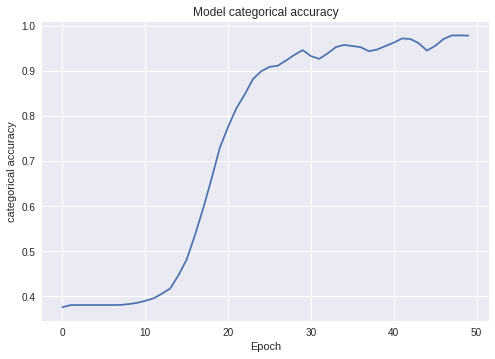

In [23]:
plt.plot(history.history['categorical_accuracy'])
plt.title('Model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('Epoch')
plt.show()

In [25]:
test = os.listdir("../input/test/")
print(len(test))

7960


In [0]:
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

In [27]:
X = prepareImages(test_df, test_df.shape[0], "test")
X /= 255

Preparing images
Processing image:  1 ,  7efc384cb.jpg
Processing image:  501 ,  925cc6cb9.jpg
Processing image:  1001 ,  704a4bf34.jpg
Processing image:  1501 ,  07fa274d3.jpg
Processing image:  2001 ,  0ade78f0b.jpg
Processing image:  2501 ,  d610e5a10.jpg
Processing image:  3001 ,  8ebfecd3d.jpg
Processing image:  3501 ,  dbe933f35.jpg
Processing image:  4001 ,  3f45b5123.jpg
Processing image:  4501 ,  e94defa0b.jpg
Processing image:  5001 ,  ecad2e839.jpg
Processing image:  5501 ,  97f72805f.jpg
Processing image:  6001 ,  11ac9fe4d.jpg
Processing image:  6501 ,  29b021120.jpg
Processing image:  7001 ,  3d4cacabc.jpg
Processing image:  7501 ,  fb51dc57e.jpg


In [28]:
predictions = model.predict(np.array(X), verbose=1)

7960/7960 [==============================] - 8s 995us/step


In [0]:
for i, pred in enumerate(predictions):
    test_df.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))

In [0]:
test_df.head(10)
test_df.to_csv('submission.csv', index=False)

In [33]:
!ls -l

total 500
-rw-r--r-- 1 root root 509449 Dec  7 18:30 submission.csv


In [0]:
files.download('submission.csv')